# Introdução à Ciência de Dados - Projeto Parte 2

<p align="justify">
Nessa etapa, iremos escolher uma das colunas do nosso dataset para para fazermos uma regressão baseada nas demais features. Avaliaremos quatro diferentes algoritmos para essa tarefa e utilizaremos o MLFlow para fazer o rastreamento. Adicionalmente, usaremos o Optuna para variar os hiperparâmetros de cada abordagem e escolher o melhor deles.

### Equipe:
> Pedro Henrique Almeida Girão Peixinho (phagp)

> Victor Gabriel de Carvalho (vgc3)

### Tópicos Avançados em Gerenciamento de Dados e Informação IF697 - 2024.1 - Centro de Informáica UFPE

In [2]:
import pandas as pd
import numpy as np

from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import KNNImputer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

import logging
import mlflow
import optuna
optuna.logging.set_verbosity(optuna.logging.INFO)
# import autosklearn.regression

tf.random.set_seed(9)
keras.utils.set_random_seed(9)

d:\Cin\Ciencia-de-Dados-Projeto-1\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---

## Pre-Processamento

In [3]:
df_cars = pd.read_csv('carscraper\cars.csv')
df_cars.head()

,page,car_brand,car_name,car_price,car_km,car_year,car_desc,car_store,car_engine,car_gearbox,car_fuel,car_color
0,https://grupoautonunes.com/estoque/?zero_km=0&...,Fiat,500E,125990.0,7521.0,2022,ICON ELÉTRICO,NaN,Elétrico,Automatico,Elétrico,NaN
1,https://grupoautonunes.com/estoque/?zero_km=0&...,Audi,Q3,128980.0,40000.0,2018,1.4 TFSI AMBIENTE FLEX 4P S TRONIC,NaN,1.4,Automatico,Flex,NaN
2,https://grupoautonunes.com/estoque/?zero_km=0&...,Chevrolet,Onix,70990.0,40686.0,2023,1.0 FLEX LT MANUAL,NaN,1.0,Manual,Flex,NaN
3,https://grupoautonunes.com/estoque/?zero_km=0&...,Chevrolet,Onix,79990.0,57643.0,2022,1.0 TURBO FLEX PLUS LTZ AUTOMÁTICO,NaN,1.0 Turbo,Automatico,Flex,NaN
4,https://grupoautonunes.com/estoque/?zero_km=0&...,Volkswagen,Saveiro,77990.0,29000.0,2023,1.6 MSI TRENDLINE CS 8V FLEX 2P MANUAL,NaN,1.6,Manual,Flex,NaN


In [4]:
df_cars.shape

(1124, 12)

In [5]:
df_cars.drop(['page', 'car_desc'], axis=1, inplace=True)
df_cars.drop_duplicates(inplace=True)

df_cars.head()

,car_brand,car_name,car_price,car_km,car_year,car_store,car_engine,car_gearbox,car_fuel,car_color
0,Fiat,500E,125990.0,7521.0,2022,NaN,Elétrico,Automatico,Elétrico,NaN
1,Audi,Q3,128980.0,40000.0,2018,NaN,1.4,Automatico,Flex,NaN
2,Chevrolet,Onix,70990.0,40686.0,2023,NaN,1.0,Manual,Flex,NaN
3,Chevrolet,Onix,79990.0,57643.0,2022,NaN,1.0 Turbo,Automatico,Flex,NaN
4,Volkswagen,Saveiro,77990.0,29000.0,2023,NaN,1.6,Manual,Flex,NaN


In [6]:
df_cars.dtypes

car_brand       object
car_name        object
car_price      float64
car_km         float64
car_year         int64
car_store       object
car_engine      object
car_gearbox     object
car_fuel        object
car_color       object
dtype: object

In [7]:
df_cars_cat = df_cars.copy()
object_columns = df_cars.select_dtypes(['object']).columns
df_cars_cat[object_columns] = df_cars[object_columns].astype('category')

df_cars_cat.dtypes

car_brand      category
car_name       category
car_price       float64
car_km          float64
car_year          int64
car_store      category
car_engine     category
car_gearbox    category
car_fuel       category
car_color      category
dtype: object

In [8]:
df_cars_cat.isnull().sum()

car_brand         0
car_name          0
car_price         0
car_km            0
car_year          0
car_store      1095
car_engine        0
car_gearbox       0
car_fuel         48
car_color       986
dtype: int64

In [9]:
df_cars_cat.dropna(thresh=0.7*len(df_cars_cat), axis=1, inplace=True)
df_cars_cat.count()

car_brand      1103
car_name       1103
car_price      1103
car_km         1103
car_year       1103
car_engine     1103
car_gearbox    1103
car_fuel       1055
dtype: int64

In [10]:
df_cars_codes = df_cars_cat.copy()
category_columns = df_cars_cat.select_dtypes(['category']).columns
df_cars_codes[category_columns] = df_cars_cat[category_columns].apply(lambda x: x.cat.codes.replace(-1, np.nan))

df_cars_codes.head()

,car_brand,car_name,car_price,car_km,car_year,car_engine,car_gearbox,car_fuel
0,8,9,125990.0,7521.0,2022,29,0,1.0
1,1,108,128980.0,40000.0,2018,6,0,2.0
2,6,96,70990.0,40686.0,2023,0,1,2.0
3,6,96,79990.0,57643.0,2022,1,0,2.0
4,29,122,77990.0,29000.0,2023,10,1,2.0


---

In [ ]:
# imputer = KNNImputer(n_neighbors=5)
# knn_fill = imputer.fit_transform(df_cars_codes)
# df_knn_fill = pd.DataFrame(data=knn_fill, columns=[df_cars_codes.columns])

# df_knn_fill.head()

In [ ]:
# df_knn_fill_ee = df_knn_fill.copy()

# detector = EllipticEnvelope(contamination=0.01, support_fraction=0.85)
# detector.fit(df_knn_fill_ee)

In [ ]:
# scores = detector.predict(df_knn_fill_ee)
# df_knn_fill_ee['outlier'] = scores

# df_knn_fill_ee.head()

In [ ]:
# df_knn_fill_ee = df_knn_fill_ee[df_knn_fill_ee['outlier'] != -1]
# df_knn_fill_ee.head()

---

In [11]:
df_median_fill = df_cars_codes.copy()

df_median_fill['car_fuel'] = df_median_fill['car_fuel'].fillna(df_median_fill['car_fuel'].median())
df_median_fill.isnull().sum()

car_brand      0
car_name       0
car_price      0
car_km         0
car_year       0
car_engine     0
car_gearbox    0
car_fuel       0
dtype: int64

In [12]:
df_median_fill_ee = df_median_fill.copy()

detector = EllipticEnvelope(contamination=0.01, support_fraction=0.85)
detector.fit(df_median_fill_ee)

scores = detector.predict(df_median_fill_ee)
df_median_fill_ee['outlier'] = scores

df_median_fill_ee['outlier'] = df_median_fill_ee['outlier'].astype('int')

df_median_fill_ee.head()

df_median_fill_ee = df_median_fill_ee[df_median_fill_ee['outlier'] != -1]
df_median_fill_ee.drop('outlier', axis=1, inplace=True)
df_median_fill_ee.count()

car_brand      1091
car_name       1091
car_price      1091
car_km         1091
car_year       1091
car_engine     1091
car_gearbox    1091
car_fuel       1091
dtype: int64

In [13]:
min_max_scaler = MinMaxScaler()
df_knn_fill_norm = min_max_scaler.fit_transform(df_median_fill_ee)
df_knn_fill_norm = pd.DataFrame(df_knn_fill_norm, columns=df_median_fill_ee.columns)
df_knn_fill_norm.head()

,car_brand,car_name,car_price,car_km,car_year,car_engine,car_gearbox,car_fuel
0,0.266667,0.057325,0.175680,0.011500,0.88,1.000000,0.0,0.2
1,0.033333,0.687898,0.180880,0.061162,0.72,0.206897,0.0,0.4
2,0.200000,0.611465,0.080013,0.062211,0.92,0.000000,1.0,0.4
3,0.200000,0.611465,0.095667,0.088139,0.88,0.034483,0.0,0.4
4,0.966667,0.777070,0.092188,0.044343,0.92,0.344828,1.0,0.4


---

## Modelos de Regressão

<p align="justify">
Os modelos de regressão são uma classe fundamental de algoritmos de aprendizado de máquina. Diferente dos modelos de classificação, que preveem categorias discretas, os modelos de regressão são empregados para tarefas onde a saída é uma variável contínua, como prever preços, temperaturas, ou outras medidas quantitativas.

<p align="justify">
A escolha do modelo apropriado depende das características do conjunto de dados e da natureza da relação entre as variáveis independentes e dependentes. Nessa etapa do projeto, avaliaremos os modelos de Linar Regression, Random Forest Regressor, Gradient Boosting Regressor e Neural Networks. Cada abordagem contará com a variação e avaliação de multiplos conjuntos de inicializações e parâmetros, fiscalizados pelo MLFlow e selecionados pelo Optuna.

<p align="justify">
Para todos os modelos, inicialmente veremos o resultado na inicialização base (default) das bibliotecas. Após isso, uma bateria de testes será feita em cada um. A métrica de avaliação majoritária será o R2 Score, amplamente utilizado em abordagens de regressão, outras métricas serão empregadas posteriormente.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_knn_fill_norm.drop('car_price', axis=1), df_knn_fill_norm['car_price'], test_size=0.2, random_state=9)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=9)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(872, 7) (110, 7) (109, 7)
(872,) (110,) (109,)


---

### Configurando o MLflow

In [15]:
mlflow.set_tracking_uri("http://localhost:5000")

### Linear Regression

<p align="justify">
A regressão linear é um método estatístico simples e amplamente utilizado para modelar a relação entre uma variável dependente contínua e uma ou mais variáveis independentes. O modelo assume que essa relação pode ser descrita por uma linha reta (ou hiperplano, em caso de regressão de multiplas variáveis). A regressão linear é popular devido à sua interpretabilidade e eficiência computacional, tornando-se uma escolha padrão para problemas de regressão simples e de pequena escala. No entanto, sua simplicidade pode ser uma limitação em casos onde a relação entre as variáveis é não linear ou complexa.

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_reg.score(X_test, y_test)

0.564700453099702

In [ ]:
lin_reg_pred = lin_reg.predict(X_test)

---

### Random Forest Regressor

<p align="justify">
O Random Forest Regressor é um poderoso algoritmo de aprendizado de máquina baseado em ensembles (método de bagging) que utiliza múltiplas árvores de decisão para melhorar a precisão preditiva e controlar o overfitting. Cada árvore no conjunto é treinada com um subconjunto aleatório dos dados e das características, e as previsões são feitas pela média das previsões individuais das árvores. O Random Forest Regressor é eficaz em capturar relações complexas e não lineares nos dados e lida bem com grandes volumes de dados.

In [ ]:
rf_reg = RandomForestRegressor(
    n_estimators=100, criterion='squared_error', min_samples_split=2, min_samples_leaf=1, 
    random_state=9
)
rf_reg.fit(X_train, y_train)
rf_reg.score(X_test, y_test)

0.8366525807532437

In [ ]:
rf_reg_pred = rf_reg.predict(X_test)

<p align="justify">
O código abaixo faz o ajuste de hiperparâmetros através do Optuna para o RandomForestRegressor. Escolhemos variar os valores de n_estimators, criterion, min_samples_split e min_samples_leaf, por serem considerados uns dos mais impactantes na performance desse tipo de regressor.

In [16]:
def objective_rf(trial):
    with mlflow.start_run(run_name="Random Forest"):
        n_estimators = trial.suggest_int('n_estimators', 20, 500)
        criterion = trial.suggest_categorical('criterion', ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'])
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        
        rf_reg_obj = RandomForestRegressor(
            n_estimators=n_estimators, criterion=criterion, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
            random_state=9
        )
        
        rf_reg_obj.fit(X_train, y_train)

        mlflow.log_param("model_type", "Random Forest")
        mlflow.log_metric("mse", rf_reg_obj.score(X_val, y_val))
        for param in trial.params:
            mlflow.log_param(param, trial.params[param])
        mlflow.sklearn.log_model(rf_reg_obj, "model")

    return rf_reg_obj.score(X_val, y_val)

In [17]:
rf_study = optuna.create_study( study_name="Study for random forest regressor", direction="maximize")
rf_study.optimize(objective_rf, n_trials=10)
print(f'\nBest trial: {rf_study.best_trial}')

[I 2024-07-11 21:47:16,993] A new study created in memory with name: Study for random forest regressor
[W 2024-07-11 21:48:46,408] Trial 0 failed with parameters: {'n_estimators': 277, 'criterion': 'friedman_mse', 'min_samples_split': 5, 'min_samples_leaf': 9} because of the following error: MlflowException("API request to http://localhost:5000/api/2.0/mlflow/runs/create failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/create (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001A87DA027D0>: Failed to establish a new connection: [WinError 10061] Nenhuma conexão pôde ser feita porque a máquina de destino as recusou ativamente'))").
Traceback (most recent call last):
  File "d:\Cin\Ciencia-de-Dados-Projeto-1\venv\Lib\site-packages\urllib3\connection.py", line 196, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Cin\Ciencia-de-Da

MlflowException: API request to http://localhost:5000/api/2.0/mlflow/runs/create failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/create (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001A87DA027D0>: Failed to establish a new connection: [WinError 10061] Nenhuma conexão pôde ser feita porque a máquina de destino as recusou ativamente'))

---

### Gradient Boosting Regressor

<p align="justify">
O Gradient Boosting Regressor é uma técnica avançada de ensemble que combina múltiplos modelos fracos para criar um modelo forte. Ele trabalha treinando sequencialmente cada novo modelo para corrigir os erros residuais dos modelos anteriores, otimizando iterativamente a função de custo através do gradiente descendente. O Gradient Boosting é altamente flexível e pode modelar relações complexas e não lineares entre as variáveis.  É amplamente utilizado em competições de ciência de dados devido à sua alta performance.

In [ ]:
gb_reg = GradientBoostingRegressor(
    loss='squared_error', learning_rate=0.1, n_estimators=100, criterion='friedman_mse',
    random_state=9
)
gb_reg.fit(X_train, y_train)
gb_reg.score(X_test, y_test)

0.8174047019583461

In [ ]:
gb_reg_pred = gb_reg.predict(X_test)

<p align="justify">
O código abaixo faz o ajuste de hiperparâmetros através do Optuna para o GradientBoostingRegressor. Escolhemos variar os valores de loss, learning_rate, n_estimators e criterion, por serem considerados uns dos mais impactantes na performance desse tipo de regressor.

In [ ]:
def objective_gb(trial):
    loss = trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber', 'quantile'])
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.5)
    n_estimators = trial.suggest_int('n_estimators', 20, 500)
    criterion = trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error'])
    
    gb_reg_obj = GradientBoostingRegressor(
        loss=loss, learning_rate=learning_rate, n_estimators=n_estimators, criterion=criterion, 
        random_state=9
    )
    
    gb_reg_obj.fit(X_train, y_train)
    return gb_reg_obj.score(X_val, y_val)

In [ ]:
gb_study = optuna.create_study( study_name="Study for gradient boosting regressor", direction="maximize")
gb_study.optimize(objective_gb, n_trials=100)
print(f'\nBest trial: {gb_study.best_trial}')

[I 2024-07-11 20:46:26,420] A new study created in memory with name: Study for gradient boosting regressor
[I 2024-07-11 20:46:27,141] Trial 0 finished with value: 0.5430159037983411 and parameters: {'loss': 'quantile', 'learning_rate': 0.23820501865943827, 'n_estimators': 453, 'criterion': 'squared_error'}. Best is trial 0 with value: 0.5430159037983411.
[I 2024-07-11 20:46:27,669] Trial 1 finished with value: 0.7396378994832098 and parameters: {'loss': 'absolute_error', 'learning_rate': 0.07485057164962022, 'n_estimators': 326, 'criterion': 'squared_error'}. Best is trial 1 with value: 0.7396378994832098.
[I 2024-07-11 20:46:28,754] Trial 2 finished with value: 0.8772335983894464 and parameters: {'loss': 'huber', 'learning_rate': 0.20457520367665766, 'n_estimators': 480, 'criterion': 'squared_error'}. Best is trial 2 with value: 0.8772335983894464.
[I 2024-07-11 20:46:29,535] Trial 3 finished with value: 0.8854055694085927 and parameters: {'loss': 'huber', 'learning_rate': 0.16077838


Best trial: FrozenTrial(number=15, state=1, values=[0.9069531470975694], datetime_start=datetime.datetime(2024, 7, 11, 20, 46, 35, 850588), datetime_complete=datetime.datetime(2024, 7, 11, 20, 46, 37, 3478), params={'loss': 'huber', 'learning_rate': 0.16453713554469904, 'n_estimators': 496, 'criterion': 'friedman_mse'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'loss': CategoricalDistribution(choices=('squared_error', 'absolute_error', 'huber', 'quantile')), 'learning_rate': FloatDistribution(high=0.5, log=False, low=0.05, step=None), 'n_estimators': IntDistribution(high=500, log=False, low=20, step=1), 'criterion': CategoricalDistribution(choices=('friedman_mse', 'squared_error'))}, trial_id=15, value=None)


---

### Artificial Neural Network

<p align="justify">
Redes neurais para regressão utilizam a arquitetura de camadas densamente conectadas para modelar relações complexas entre variáveis de entrada e uma variável de saída contínua. Cada camada de neurônios aplica uma transformação linear seguida de uma função de ativação não linear, permitindo que a rede capture padrões complexos nos dados. No entanto, apesar de sua notável performance e aplicabilidade, elas requerem uma grande quantidade de dados para treinar de forma eficaz e são mais propensas a overfitting.

In [ ]:
nn_reg = tf.keras.Sequential([
    keras.Input(shape=(X_train.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1),
])

optimizer = tf.keras.optimizers.Adam(0.001)
nn_reg.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'r2_score'])

nn_reg.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 16)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,217 (4.75 KB)

 Trainable params: 1,217 (4.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

nn_reg.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0264 - mae: 0.0882 - r2_score: -0.0590 - val_loss: 0.0124 - val_mae: 0.0619 - val_r2_score: 0.3162
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165 - mae: 0.0682 - r2_score: 0.3256 - val_loss: 0.0116 - val_mae: 0.0550 - val_r2_score: 0.3583
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0159 - mae: 0.0631 - r2_score: 0.3525 - val_loss: 0.0112 - val_mae: 0.0542 - val_r2_score: 0.3805
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0153 - mae: 0.0625 - r2_score: 0.3766 - val_loss: 0.0107 - val_mae: 0.0532 - val_r2_score: 0.4088
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148 - mae: 0.0614 - r2_score: 0.3965 - val_loss: 0.0101 - val_mae: 0.0520 - val_r2_score: 0.4420
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143 - mae: 0.0605 - r2_score: 0.4183 - val_loss: 0.0097 - val_mae: 0.0515 - val_r2_score: 0.4662
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

In [ ]:
nn_reg.evaluate(X_test, y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - mae: 0.0361 - r2_score: 0.8046 


[0.004316628444939852, 0.03915241360664368, 0.7429929971694946]

In [ ]:
nn_reg_pred = nn_reg.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


<p align="justify">
O código abaixo faz o ajuste de hiperparâmetros através do Optuna para o Neural Network Regressor. Escolhemos variar os valores de n_layers, weight_decay, n_units e activation, por serem considerados uns dos mais impactantes na performance desse tipo de regressor.

In [ ]:
def create_model(trial):
    n_layers = trial.suggest_int('n_layers', 1, 5)
    weight_decay = trial.suggest_float("weight_decay", 1e-10, 1e-3, log=True)
    
    model = tf.keras.Sequential()
    model.add(keras.Input(shape=(X_train.shape[1],)))
    
    for i in range(n_layers):
        n_units = trial.suggest_int(f'n_units_{i}', 4, 128)
        activation = trial.suggest_categorical(f'activation_{i}', ['relu', 'tanh', 'sigmoid', 'linear'])
        
        model.add(
            layers.Dense(
                n_units, activation=activation, kernel_regularizer=keras.regularizers.l2(weight_decay)
            )
        )
    
    model.add(layers.Dense(1))
    
    return model

def create_optimizer(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    optimizer = tf.keras.optimizers.Adam(lr)
    
    return optimizer

In [ ]:
def objective_nn(trial):
    model = create_model(trial)
    optimizer = create_optimizer(trial)
    
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'r2_score'])
    
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stop], verbose=0)
    
    return model.evaluate(X_test, y_test, verbose=0)[2]

In [ ]:
study = optuna.create_study( study_name="Study for neural network regressor", direction="maximize")
study.optimize(objective_nn, n_trials=100)
print(study.best_trial)

[I 2024-07-11 20:48:58,301] A new study created in memory with name: Study for neural network regressor


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155 - mae: 0.0516 - r2_score: 0.5456 


[I 2024-07-11 20:49:06,397] Trial 0 finished with value: 0.5444973111152649 and parameters: {'n_layers': 4, 'weight_decay': 0.000903765778016118, 'n_units_0': 40, 'activation_0': 'linear', 'n_units_1': 11, 'activation_1': 'tanh', 'n_units_2': 126, 'activation_2': 'linear', 'n_units_3': 122, 'activation_3': 'tanh', 'lr': 0.00026562131670520325}. Best is trial 0 with value: 0.5444973111152649.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 - mae: 0.0671 - r2_score: 0.2839 


[I 2024-07-11 20:49:08,681] Trial 1 finished with value: 0.2546149492263794 and parameters: {'n_layers': 3, 'weight_decay': 3.888279422503311e-08, 'n_units_0': 30, 'activation_0': 'tanh', 'n_units_1': 128, 'activation_1': 'sigmoid', 'n_units_2': 114, 'activation_2': 'relu', 'lr': 0.00032874509864748436}. Best is trial 0 with value: 0.5444973111152649.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - mae: 0.0515 - r2_score: 0.5345 


[I 2024-07-11 20:49:10,477] Trial 2 finished with value: 0.5169340372085571 and parameters: {'n_layers': 2, 'weight_decay': 5.755974263174569e-10, 'n_units_0': 51, 'activation_0': 'tanh', 'n_units_1': 59, 'activation_1': 'linear', 'lr': 0.004765100488649018}. Best is trial 0 with value: 0.5444973111152649.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081 - mae: 0.0529 - r2_score: 0.5357 


[I 2024-07-11 20:49:12,785] Trial 3 finished with value: 0.5422408580780029 and parameters: {'n_layers': 1, 'weight_decay': 0.00010079179160355958, 'n_units_0': 102, 'activation_0': 'linear', 'lr': 0.0012783886197649558}. Best is trial 0 with value: 0.5444973111152649.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047 - mae: 0.0418 - r2_score: 0.7097 


[I 2024-07-11 20:49:18,168] Trial 4 finished with value: 0.646216630935669 and parameters: {'n_layers': 3, 'weight_decay': 1.5348499720302595e-06, 'n_units_0': 48, 'activation_0': 'relu', 'n_units_1': 108, 'activation_1': 'linear', 'n_units_2': 107, 'activation_2': 'tanh', 'lr': 0.00013723891336242245}. Best is trial 4 with value: 0.646216630935669.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101 - mae: 0.0597 - r2_score: 0.3330 


[I 2024-07-11 20:49:26,392] Trial 5 finished with value: 0.2824856638908386 and parameters: {'n_layers': 5, 'weight_decay': 1.0255610904678169e-07, 'n_units_0': 115, 'activation_0': 'sigmoid', 'n_units_1': 97, 'activation_1': 'relu', 'n_units_2': 54, 'activation_2': 'sigmoid', 'n_units_3': 8, 'activation_3': 'relu', 'n_units_4': 55, 'activation_4': 'tanh', 'lr': 6.004154798352474e-05}. Best is trial 4 with value: 0.646216630935669.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - mae: 0.0417 - r2_score: 0.6602 


[I 2024-07-11 20:49:29,079] Trial 6 finished with value: 0.6241804957389832 and parameters: {'n_layers': 5, 'weight_decay': 1.5405088898873792e-08, 'n_units_0': 112, 'activation_0': 'relu', 'n_units_1': 87, 'activation_1': 'sigmoid', 'n_units_2': 100, 'activation_2': 'linear', 'n_units_3': 95, 'activation_3': 'tanh', 'n_units_4': 91, 'activation_4': 'relu', 'lr': 0.0013075963377854518}. Best is trial 4 with value: 0.646216630935669.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029 - mae: 0.0320 - r2_score: 0.8095 


[I 2024-07-11 20:49:32,642] Trial 7 finished with value: 0.7457281947135925 and parameters: {'n_layers': 5, 'weight_decay': 2.46671143512715e-09, 'n_units_0': 54, 'activation_0': 'relu', 'n_units_1': 84, 'activation_1': 'linear', 'n_units_2': 127, 'activation_2': 'tanh', 'n_units_3': 84, 'activation_3': 'relu', 'n_units_4': 105, 'activation_4': 'linear', 'lr': 0.0032067090755254824}. Best is trial 7 with value: 0.7457281947135925.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - mae: 0.0489 - r2_score: 0.6572 


[I 2024-07-11 20:49:37,506] Trial 8 finished with value: 0.6348251104354858 and parameters: {'n_layers': 4, 'weight_decay': 4.800327746837245e-08, 'n_units_0': 43, 'activation_0': 'sigmoid', 'n_units_1': 11, 'activation_1': 'tanh', 'n_units_2': 20, 'activation_2': 'relu', 'n_units_3': 12, 'activation_3': 'linear', 'lr': 0.0011133037052027802}. Best is trial 7 with value: 0.7457281947135925.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - mae: 0.0442 - r2_score: 0.7157 


[I 2024-07-11 20:49:40,216] Trial 9 finished with value: 0.6639320850372314 and parameters: {'n_layers': 3, 'weight_decay': 3.2508562581072983e-06, 'n_units_0': 5, 'activation_0': 'relu', 'n_units_1': 5, 'activation_1': 'relu', 'n_units_2': 21, 'activation_2': 'relu', 'lr': 0.009321521376879803}. Best is trial 7 with value: 0.7457281947135925.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0152 - mae: 0.0804 - r2_score: -0.0135 


[I 2024-07-11 20:49:42,405] Trial 10 finished with value: -0.012318611145019531 and parameters: {'n_layers': 5, 'weight_decay': 3.3933991579593084e-10, 'n_units_0': 79, 'activation_0': 'relu', 'n_units_1': 57, 'activation_1': 'linear', 'n_units_2': 74, 'activation_2': 'tanh', 'n_units_3': 58, 'activation_3': 'sigmoid', 'n_units_4': 125, 'activation_4': 'linear', 'lr': 0.09535408597329084}. Best is trial 7 with value: 0.7457281947135925.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048 - mae: 0.0445 - r2_score: 0.6840 


[I 2024-07-11 20:49:44,159] Trial 11 finished with value: 0.6535770893096924 and parameters: {'n_layers': 2, 'weight_decay': 2.5168972542960875e-06, 'n_units_0': 10, 'activation_0': 'relu', 'n_units_1': 34, 'activation_1': 'relu', 'lr': 0.019131169496387615}. Best is trial 7 with value: 0.7457281947135925.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043 - mae: 0.0440 - r2_score: 0.7376 


[I 2024-07-11 20:49:47,452] Trial 12 finished with value: 0.6732080578804016 and parameters: {'n_layers': 4, 'weight_decay': 1.1798398146153155e-05, 'n_units_0': 8, 'activation_0': 'relu', 'n_units_1': 75, 'activation_1': 'relu', 'n_units_2': 9, 'activation_2': 'relu', 'n_units_3': 62, 'activation_3': 'relu', 'lr': 0.009001512632419922}. Best is trial 7 with value: 0.7457281947135925.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048 - mae: 0.0434 - r2_score: 0.6871 


[I 2024-07-11 20:49:50,065] Trial 13 finished with value: 0.6353076696395874 and parameters: {'n_layers': 4, 'weight_decay': 3.0665983614740647e-09, 'n_units_0': 79, 'activation_0': 'relu', 'n_units_1': 80, 'activation_1': 'relu', 'n_units_2': 56, 'activation_2': 'tanh', 'n_units_3': 64, 'activation_3': 'relu', 'lr': 0.03609997566039517}. Best is trial 7 with value: 0.7457281947135925.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146 - mae: 0.0653 - r2_score: 0.1488 


[I 2024-07-11 20:49:58,129] Trial 14 finished with value: 0.11691945791244507 and parameters: {'n_layers': 4, 'weight_decay': 3.0520619614781655e-05, 'n_units_0': 23, 'activation_0': 'relu', 'n_units_1': 69, 'activation_1': 'linear', 'n_units_2': 5, 'activation_2': 'sigmoid', 'n_units_3': 84, 'activation_3': 'relu', 'lr': 1.2988642147176331e-05}. Best is trial 7 with value: 0.7457281947135925.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039 - mae: 0.0365 - r2_score: 0.7568 


[I 2024-07-11 20:50:00,695] Trial 15 finished with value: 0.6892846822738647 and parameters: {'n_layers': 5, 'weight_decay': 6.380975269488238e-07, 'n_units_0': 65, 'activation_0': 'relu', 'n_units_1': 43, 'activation_1': 'linear', 'n_units_2': 78, 'activation_2': 'relu', 'n_units_3': 58, 'activation_3': 'relu', 'n_units_4': 4, 'activation_4': 'linear', 'lr': 0.004498310991430246}. Best is trial 7 with value: 0.7457281947135925.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071 - mae: 0.0564 - r2_score: 0.5261 


[I 2024-07-11 20:50:03,782] Trial 16 finished with value: 0.5259151458740234 and parameters: {'n_layers': 5, 'weight_decay': 2.883828041100043e-07, 'n_units_0': 68, 'activation_0': 'sigmoid', 'n_units_1': 35, 'activation_1': 'linear', 'n_units_2': 83, 'activation_2': 'tanh', 'n_units_3': 40, 'activation_3': 'relu', 'n_units_4': 13, 'activation_4': 'linear', 'lr': 0.0036858879030399723}. Best is trial 7 with value: 0.7457281947135925.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0083 - mae: 0.0587 - r2_score: 0.4412 


[I 2024-07-11 20:50:09,560] Trial 17 finished with value: 0.4403238892555237 and parameters: {'n_layers': 5, 'weight_decay': 4.091921116239339e-09, 'n_units_0': 63, 'activation_0': 'tanh', 'n_units_1': 42, 'activation_1': 'linear', 'n_units_2': 88, 'activation_2': 'relu', 'n_units_3': 97, 'activation_3': 'linear', 'n_units_4': 11, 'activation_4': 'linear', 'lr': 0.037512437605459754}. Best is trial 7 with value: 0.7457281947135925.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 - mae: 0.0419 - r2_score: 0.6504 


[I 2024-07-11 20:50:12,800] Trial 18 finished with value: 0.6195237040519714 and parameters: {'n_layers': 5, 'weight_decay': 4.57391693567397e-07, 'n_units_0': 89, 'activation_0': 'linear', 'n_units_1': 48, 'activation_1': 'linear', 'n_units_2': 46, 'activation_2': 'tanh', 'n_units_3': 38, 'activation_3': 'sigmoid', 'n_units_4': 72, 'activation_4': 'linear', 'lr': 0.003169190307486753}. Best is trial 7 with value: 0.7457281947135925.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - mae: 0.0392 - r2_score: 0.6737 


[I 2024-07-11 20:50:19,864] Trial 19 finished with value: 0.617836594581604 and parameters: {'n_layers': 3, 'weight_decay': 1.0893281787416418e-10, 'n_units_0': 61, 'activation_0': 'relu', 'n_units_1': 26, 'activation_1': 'linear', 'n_units_2': 38, 'activation_2': 'linear', 'lr': 0.0004534149089447227}. Best is trial 7 with value: 0.7457281947135925.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - mae: 0.0358 - r2_score: 0.7726 


[I 2024-07-11 20:50:22,196] Trial 20 finished with value: 0.7175657153129578 and parameters: {'n_layers': 2, 'weight_decay': 4.8543530962548075e-09, 'n_units_0': 95, 'activation_0': 'relu', 'n_units_1': 111, 'activation_1': 'tanh', 'lr': 0.0023199074093373205}. Best is trial 7 with value: 0.7457281947135925.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038 - mae: 0.0392 - r2_score: 0.7494 


[I 2024-07-11 20:50:24,083] Trial 21 finished with value: 0.7080626487731934 and parameters: {'n_layers': 2, 'weight_decay': 4.091473748088433e-09, 'n_units_0': 98, 'activation_0': 'relu', 'n_units_1': 124, 'activation_1': 'tanh', 'lr': 0.002361732958401183}. Best is trial 7 with value: 0.7457281947135925.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047 - mae: 0.0374 - r2_score: 0.6809 


[I 2024-07-11 20:50:26,831] Trial 22 finished with value: 0.673924446105957 and parameters: {'n_layers': 2, 'weight_decay': 2.653765657919018e-09, 'n_units_0': 101, 'activation_0': 'relu', 'n_units_1': 126, 'activation_1': 'tanh', 'lr': 0.0020634539120917817}. Best is trial 7 with value: 0.7457281947135925.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - mae: 0.0390 - r2_score: 0.7722 


[I 2024-07-11 20:50:29,994] Trial 23 finished with value: 0.729629397392273 and parameters: {'n_layers': 1, 'weight_decay': 9.21884511233013e-09, 'n_units_0': 127, 'activation_0': 'relu', 'lr': 0.0007754083751501971}. Best is trial 7 with value: 0.7457281947135925.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - mae: 0.0357 - r2_score: 0.7674 


[I 2024-07-11 20:50:35,181] Trial 24 finished with value: 0.7101127505302429 and parameters: {'n_layers': 1, 'weight_decay': 7.378442574096818e-10, 'n_units_0': 121, 'activation_0': 'relu', 'lr': 0.0005898667463363845}. Best is trial 7 with value: 0.7457281947135925.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038 - mae: 0.0375 - r2_score: 0.7527 


[I 2024-07-11 20:50:41,996] Trial 25 finished with value: 0.7155662178993225 and parameters: {'n_layers': 1, 'weight_decay': 1.3831974932440223e-08, 'n_units_0': 88, 'activation_0': 'relu', 'lr': 0.00012351808892611087}. Best is trial 7 with value: 0.7457281947135925.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0072 - mae: 0.0517 - r2_score: 0.5201 


[I 2024-07-11 20:50:43,369] Trial 26 finished with value: 0.5065444111824036 and parameters: {'n_layers': 1, 'weight_decay': 1.1965336993889855e-08, 'n_units_0': 128, 'activation_0': 'linear', 'lr': 0.009970756380753641}. Best is trial 7 with value: 0.7457281947135925.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0083 - mae: 0.0564 - r2_score: 0.4453 


[I 2024-07-11 20:50:46,121] Trial 27 finished with value: 0.42109209299087524 and parameters: {'n_layers': 2, 'weight_decay': 1.1061399296953714e-10, 'n_units_0': 114, 'activation_0': 'sigmoid', 'n_units_1': 110, 'activation_1': 'tanh', 'lr': 0.0006983855317913326}. Best is trial 7 with value: 0.7457281947135925.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0081 - mae: 0.0580 - r2_score: 0.4621 


[I 2024-07-11 20:50:52,926] Trial 28 finished with value: 0.4424431324005127 and parameters: {'n_layers': 1, 'weight_decay': 1.0564120678160519e-09, 'n_units_0': 77, 'activation_0': 'tanh', 'lr': 5.35233595435667e-05}. Best is trial 7 with value: 0.7457281947135925.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0248 - mae: 0.0533 - r2_score: 0.4782 


[I 2024-07-11 20:51:00,147] Trial 29 finished with value: 0.4580819010734558 and parameters: {'n_layers': 2, 'weight_decay': 0.0009663599606915894, 'n_units_0': 90, 'activation_0': 'linear', 'n_units_1': 96, 'activation_1': 'sigmoid', 'lr': 0.00020993140871597836}. Best is trial 7 with value: 0.7457281947135925.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - mae: 0.0327 - r2_score: 0.8193 


[I 2024-07-11 20:51:03,231] Trial 30 finished with value: 0.7603436708450317 and parameters: {'n_layers': 1, 'weight_decay': 1.1876535332201988e-07, 'n_units_0': 127, 'activation_0': 'relu', 'lr': 0.006399391727836228}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - mae: 0.0394 - r2_score: 0.7586 


[I 2024-07-11 20:51:05,234] Trial 31 finished with value: 0.7183609008789062 and parameters: {'n_layers': 1, 'weight_decay': 9.964542484253705e-08, 'n_units_0': 122, 'activation_0': 'relu', 'lr': 0.00670908787657941}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 - mae: 0.0383 - r2_score: 0.7778 


[I 2024-07-11 20:51:07,666] Trial 32 finished with value: 0.7252835035324097 and parameters: {'n_layers': 1, 'weight_decay': 8.597360200811956e-08, 'n_units_0': 128, 'activation_0': 'relu', 'lr': 0.017023587264914906}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - mae: 0.0351 - r2_score: 0.7900 


[I 2024-07-11 20:51:10,213] Trial 33 finished with value: 0.7221380472183228 and parameters: {'n_layers': 1, 'weight_decay': 4.1612384544628016e-08, 'n_units_0': 128, 'activation_0': 'relu', 'lr': 0.023331594353306926}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077 - mae: 0.0532 - r2_score: 0.4859 


[I 2024-07-11 20:51:11,618] Trial 34 finished with value: 0.4868130683898926 and parameters: {'n_layers': 1, 'weight_decay': 1.896927303020688e-07, 'n_units_0': 110, 'activation_0': 'tanh', 'lr': 0.08524320429690234}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 - mae: 0.0357 - r2_score: 0.7781 


[I 2024-07-11 20:51:13,904] Trial 35 finished with value: 0.7141420245170593 and parameters: {'n_layers': 1, 'weight_decay': 3.975121378534574e-08, 'n_units_0': 106, 'activation_0': 'relu', 'lr': 0.018298537149172373}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 - mae: 0.0370 - r2_score: 0.7720 


[I 2024-07-11 20:51:16,816] Trial 36 finished with value: 0.7298926115036011 and parameters: {'n_layers': 2, 'weight_decay': 1.3684405760401991e-08, 'n_units_0': 31, 'activation_0': 'relu', 'n_units_1': 89, 'activation_1': 'sigmoid', 'lr': 0.005678565676547369}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077 - mae: 0.0559 - r2_score: 0.4847 


[I 2024-07-11 20:51:19,726] Trial 37 finished with value: 0.4740830063819885 and parameters: {'n_layers': 3, 'weight_decay': 1.3798163509529863e-08, 'n_units_0': 28, 'activation_0': 'linear', 'n_units_1': 91, 'activation_1': 'sigmoid', 'n_units_2': 123, 'activation_2': 'sigmoid', 'lr': 0.001329154908503695}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072 - mae: 0.0539 - r2_score: 0.5171 


[I 2024-07-11 20:51:21,458] Trial 38 finished with value: 0.5107253193855286 and parameters: {'n_layers': 2, 'weight_decay': 9.052006912571719e-09, 'n_units_0': 37, 'activation_0': 'tanh', 'n_units_1': 84, 'activation_1': 'sigmoid', 'lr': 0.006684930307257886}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072 - mae: 0.0542 - r2_score: 0.5196 


[I 2024-07-11 20:51:28,598] Trial 39 finished with value: 0.5122318863868713 and parameters: {'n_layers': 2, 'weight_decay': 1.3209759337319457e-09, 'n_units_0': 54, 'activation_0': 'sigmoid', 'n_units_1': 67, 'activation_1': 'sigmoid', 'lr': 0.00032272365528416294}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - mae: 0.0400 - r2_score: 0.7708 


[I 2024-07-11 20:51:31,712] Trial 40 finished with value: 0.7269465923309326 and parameters: {'n_layers': 3, 'weight_decay': 2.4516376813591613e-10, 'n_units_0': 38, 'activation_0': 'relu', 'n_units_1': 102, 'activation_1': 'sigmoid', 'n_units_2': 96, 'activation_2': 'tanh', 'lr': 0.0018155051536573018}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050 - mae: 0.0392 - r2_score: 0.6767 


[I 2024-07-11 20:51:34,317] Trial 41 finished with value: 0.604547381401062 and parameters: {'n_layers': 3, 'weight_decay': 3.378941887388513e-10, 'n_units_0': 39, 'activation_0': 'relu', 'n_units_1': 103, 'activation_1': 'sigmoid', 'n_units_2': 101, 'activation_2': 'tanh', 'lr': 0.0018137405222791393}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066 - mae: 0.0461 - r2_score: 0.5686 


[I 2024-07-11 20:51:37,342] Trial 42 finished with value: 0.5263159871101379 and parameters: {'n_layers': 3, 'weight_decay': 3.623952580055509e-10, 'n_units_0': 22, 'activation_0': 'relu', 'n_units_1': 117, 'activation_1': 'sigmoid', 'n_units_2': 92, 'activation_2': 'tanh', 'lr': 0.0006964342843670214}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - mae: 0.0455 - r2_score: 0.5967 


[I 2024-07-11 20:51:39,642] Trial 43 finished with value: 0.5595042705535889 and parameters: {'n_layers': 3, 'weight_decay': 1.8552724450606635e-09, 'n_units_0': 50, 'activation_0': 'relu', 'n_units_1': 77, 'activation_1': 'sigmoid', 'n_units_2': 116, 'activation_2': 'tanh', 'lr': 0.0010006291326882441}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0181 - mae: 0.0387 - r2_score: 0.6638 


[I 2024-07-11 20:51:47,862] Trial 44 finished with value: 0.6340531706809998 and parameters: {'n_layers': 4, 'weight_decay': 0.0002802466643882172, 'n_units_0': 33, 'activation_0': 'relu', 'n_units_1': 99, 'activation_1': 'sigmoid', 'n_units_2': 128, 'activation_2': 'tanh', 'n_units_3': 120, 'activation_3': 'tanh', 'lr': 0.0048820442382006965}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - mae: 0.0343 - r2_score: 0.8085 


[I 2024-07-11 20:51:54,300] Trial 45 finished with value: 0.7492938041687012 and parameters: {'n_layers': 2, 'weight_decay': 2.294166081172248e-08, 'n_units_0': 44, 'activation_0': 'relu', 'n_units_1': 59, 'activation_1': 'sigmoid', 'lr': 0.001689217676919855}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050 - mae: 0.0447 - r2_score: 0.6690 


[I 2024-07-11 20:51:56,063] Trial 46 finished with value: 0.6270662546157837 and parameters: {'n_layers': 2, 'weight_decay': 2.893320834935937e-08, 'n_units_0': 56, 'activation_0': 'relu', 'n_units_1': 59, 'activation_1': 'sigmoid', 'lr': 0.01051361455290223}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - mae: 0.0401 - r2_score: 0.7695 


[I 2024-07-11 20:51:59,453] Trial 47 finished with value: 0.7324835062026978 and parameters: {'n_layers': 2, 'weight_decay': 2.4375028676500638e-08, 'n_units_0': 45, 'activation_0': 'relu', 'n_units_1': 55, 'activation_1': 'sigmoid', 'lr': 0.0032016048810135436}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039 - mae: 0.0439 - r2_score: 0.7496 


[I 2024-07-11 20:52:02,572] Trial 48 finished with value: 0.7036734223365784 and parameters: {'n_layers': 2, 'weight_decay': 1.00834244837558e-06, 'n_units_0': 47, 'activation_0': 'relu', 'n_units_1': 54, 'activation_1': 'sigmoid', 'lr': 0.005611824630529394}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074 - mae: 0.0538 - r2_score: 0.5106 


[I 2024-07-11 20:52:04,826] Trial 49 finished with value: 0.4945738911628723 and parameters: {'n_layers': 2, 'weight_decay': 1.4033862837333493e-07, 'n_units_0': 16, 'activation_0': 'sigmoid', 'n_units_1': 71, 'activation_1': 'sigmoid', 'lr': 0.011183947082566533}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037 - mae: 0.0451 - r2_score: 0.7581 


[I 2024-07-11 20:52:08,423] Trial 50 finished with value: 0.7091019153594971 and parameters: {'n_layers': 4, 'weight_decay': 6.716302811613612e-08, 'n_units_0': 44, 'activation_0': 'relu', 'n_units_1': 88, 'activation_1': 'sigmoid', 'n_units_2': 60, 'activation_2': 'sigmoid', 'n_units_3': 82, 'activation_3': 'linear', 'lr': 0.0043337824603464515}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038 - mae: 0.0469 - r2_score: 0.7454 


[I 2024-07-11 20:52:12,547] Trial 51 finished with value: 0.7193578481674194 and parameters: {'n_layers': 2, 'weight_decay': 2.433944067288118e-08, 'n_units_0': 72, 'activation_0': 'relu', 'n_units_1': 62, 'activation_1': 'sigmoid', 'lr': 0.0034646876573504034}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045 - mae: 0.0380 - r2_score: 0.7108 


[I 2024-07-11 20:52:15,809] Trial 52 finished with value: 0.6702225208282471 and parameters: {'n_layers': 1, 'weight_decay': 6.888866174225103e-09, 'n_units_0': 31, 'activation_0': 'relu', 'lr': 0.0014751955950991734}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037 - mae: 0.0369 - r2_score: 0.7622 


[I 2024-07-11 20:52:18,704] Trial 53 finished with value: 0.6954653263092041 and parameters: {'n_layers': 1, 'weight_decay': 2.2888619814781868e-08, 'n_units_0': 57, 'activation_0': 'relu', 'lr': 0.0031789441184349836}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - mae: 0.0374 - r2_score: 0.7700 


[I 2024-07-11 20:52:26,326] Trial 54 finished with value: 0.712640643119812 and parameters: {'n_layers': 2, 'weight_decay': 2.343602083031973e-07, 'n_units_0': 45, 'activation_0': 'relu', 'n_units_1': 22, 'activation_1': 'sigmoid', 'lr': 0.0026623195739720663}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042 - mae: 0.0379 - r2_score: 0.7290 


[I 2024-07-11 20:52:32,979] Trial 55 finished with value: 0.6707297563552856 and parameters: {'n_layers': 1, 'weight_decay': 6.5843862726354685e-09, 'n_units_0': 26, 'activation_0': 'relu', 'lr': 0.0010133374616032107}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043 - mae: 0.0375 - r2_score: 0.7467 


[I 2024-07-11 20:52:35,764] Trial 56 finished with value: 0.6761683225631714 and parameters: {'n_layers': 2, 'weight_decay': 5.52791031323784e-06, 'n_units_0': 119, 'activation_0': 'relu', 'n_units_1': 49, 'activation_1': 'linear', 'lr': 0.0004726844828596336}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040 - mae: 0.0420 - r2_score: 0.7369 


[I 2024-07-11 20:52:38,540] Trial 57 finished with value: 0.7076412439346313 and parameters: {'n_layers': 3, 'weight_decay': 2.4003159172041294e-09, 'n_units_0': 17, 'activation_0': 'relu', 'n_units_1': 81, 'activation_1': 'relu', 'n_units_2': 32, 'activation_2': 'linear', 'lr': 0.007748001800029064}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 - mae: 0.0524 - r2_score: 0.5482 


[I 2024-07-11 20:52:41,154] Trial 58 finished with value: 0.5445129871368408 and parameters: {'n_layers': 1, 'weight_decay': 2.3017461584088114e-08, 'n_units_0': 51, 'activation_0': 'linear', 'lr': 0.0007804950878357713}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073 - mae: 0.0536 - r2_score: 0.5144 


[I 2024-07-11 20:52:42,959] Trial 59 finished with value: 0.504761815071106 and parameters: {'n_layers': 2, 'weight_decay': 6.134497056610993e-08, 'n_units_0': 61, 'activation_0': 'tanh', 'n_units_1': 71, 'activation_1': 'sigmoid', 'lr': 0.013214286966470918}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 - mae: 0.0356 - r2_score: 0.7777 


[I 2024-07-11 20:52:46,900] Trial 60 finished with value: 0.7271161079406738 and parameters: {'n_layers': 3, 'weight_decay': 3.33489773212224e-07, 'n_units_0': 35, 'activation_0': 'relu', 'n_units_1': 92, 'activation_1': 'linear', 'n_units_2': 74, 'activation_2': 'sigmoid', 'lr': 0.0014911907520051616}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - mae: 0.0357 - r2_score: 0.7866 


[I 2024-07-11 20:52:53,598] Trial 61 finished with value: 0.7516871690750122 and parameters: {'n_layers': 3, 'weight_decay': 6.452368686000354e-07, 'n_units_0': 35, 'activation_0': 'relu', 'n_units_1': 64, 'activation_1': 'linear', 'n_units_2': 66, 'activation_2': 'sigmoid', 'lr': 0.0015975872042717748}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043 - mae: 0.0376 - r2_score: 0.7236 


[I 2024-07-11 20:52:55,687] Trial 62 finished with value: 0.6860169172286987 and parameters: {'n_layers': 3, 'weight_decay': 1.0302514635081123e-06, 'n_units_0': 42, 'activation_0': 'relu', 'n_units_1': 64, 'activation_1': 'linear', 'n_units_2': 64, 'activation_2': 'sigmoid', 'lr': 0.0031319717945152347}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - mae: 0.0398 - r2_score: 0.7680 


[I 2024-07-11 20:53:00,213] Trial 63 finished with value: 0.7178474068641663 and parameters: {'n_layers': 4, 'weight_decay': 1.4814474348700122e-07, 'n_units_0': 69, 'activation_0': 'relu', 'n_units_1': 53, 'activation_1': 'linear', 'n_units_2': 50, 'activation_2': 'sigmoid', 'n_units_3': 105, 'activation_3': 'sigmoid', 'lr': 0.0022967859842022214}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - mae: 0.0474 - r2_score: 0.7092 


[I 2024-07-11 20:53:03,092] Trial 64 finished with value: 0.677043080329895 and parameters: {'n_layers': 5, 'weight_decay': 4.714439025528052e-07, 'n_units_0': 32, 'activation_0': 'relu', 'n_units_1': 73, 'activation_1': 'linear', 'n_units_2': 68, 'activation_2': 'linear', 'n_units_3': 37, 'activation_3': 'relu', 'n_units_4': 127, 'activation_4': 'sigmoid', 'lr': 0.00533567503730148}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048 - mae: 0.0369 - r2_score: 0.6994 


[I 2024-07-11 20:53:09,842] Trial 65 finished with value: 0.6373401284217834 and parameters: {'n_layers': 2, 'weight_decay': 2.278894631323745e-06, 'n_units_0': 41, 'activation_0': 'relu', 'n_units_1': 79, 'activation_1': 'relu', 'lr': 0.00020829498634534848}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0067 - mae: 0.0536 - r2_score: 0.5488 


[I 2024-07-11 20:53:16,609] Trial 66 finished with value: 0.5492037534713745 and parameters: {'n_layers': 1, 'weight_decay': 3.5803581985061367e-09, 'n_units_0': 52, 'activation_0': 'sigmoid', 'lr': 0.0004742866143452805}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0037 - mae: 0.0365 - r2_score: 0.7635 


[I 2024-07-11 20:53:22,670] Trial 67 finished with value: 0.7023712992668152 and parameters: {'n_layers': 1, 'weight_decay': 7.848683476259982e-09, 'n_units_0': 59, 'activation_0': 'relu', 'lr': 0.0008312581228724802}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0115 - mae: 0.0617 - r2_score: 0.2382 


[I 2024-07-11 20:53:30,849] Trial 68 finished with value: 0.2058998942375183 and parameters: {'n_layers': 4, 'weight_decay': 1.8568076564883747e-08, 'n_units_0': 24, 'activation_0': 'relu', 'n_units_1': 38, 'activation_1': 'linear', 'n_units_2': 111, 'activation_2': 'sigmoid', 'n_units_3': 78, 'activation_3': 'tanh', 'lr': 1.0360537659691133e-05}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050 - mae: 0.0541 - r2_score: 0.6705 


[I 2024-07-11 20:53:32,690] Trial 69 finished with value: 0.6132875680923462 and parameters: {'n_layers': 2, 'weight_decay': 3.716141555169298e-08, 'n_units_0': 124, 'activation_0': 'relu', 'n_units_1': 61, 'activation_1': 'linear', 'lr': 0.02582967197240698}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 - mae: 0.0515 - r2_score: 0.5445 


[I 2024-07-11 20:53:35,142] Trial 70 finished with value: 0.54482102394104 and parameters: {'n_layers': 3, 'weight_decay': 9.782128064290946e-08, 'n_units_0': 18, 'activation_0': 'linear', 'n_units_1': 47, 'activation_1': 'linear', 'n_units_2': 35, 'activation_2': 'sigmoid', 'lr': 0.0012312933908122704}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037 - mae: 0.0351 - r2_score: 0.7628 


[I 2024-07-11 20:53:40,864] Trial 71 finished with value: 0.7178497314453125 and parameters: {'n_layers': 3, 'weight_decay': 4.341897209951352e-07, 'n_units_0': 37, 'activation_0': 'relu', 'n_units_1': 93, 'activation_1': 'linear', 'n_units_2': 74, 'activation_2': 'sigmoid', 'lr': 0.0016418944469990897}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037 - mae: 0.0351 - r2_score: 0.7600 


[I 2024-07-11 20:53:43,986] Trial 72 finished with value: 0.7210787534713745 and parameters: {'n_layers': 3, 'weight_decay': 3.004083014458594e-07, 'n_units_0': 34, 'activation_0': 'relu', 'n_units_1': 89, 'activation_1': 'linear', 'n_units_2': 85, 'activation_2': 'sigmoid', 'lr': 0.0020913972922591935}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039 - mae: 0.0374 - r2_score: 0.7460 


[I 2024-07-11 20:53:46,187] Trial 73 finished with value: 0.6654149293899536 and parameters: {'n_layers': 3, 'weight_decay': 1.1887125022136678e-08, 'n_units_0': 29, 'activation_0': 'relu', 'n_units_1': 82, 'activation_1': 'linear', 'n_units_2': 67, 'activation_2': 'sigmoid', 'lr': 0.0041670593533558445}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0035 - mae: 0.0348 - r2_score: 0.7670 


[I 2024-07-11 20:53:50,808] Trial 74 finished with value: 0.6983568668365479 and parameters: {'n_layers': 2, 'weight_decay': 5.593203279118936e-08, 'n_units_0': 47, 'activation_0': 'relu', 'n_units_1': 65, 'activation_1': 'linear', 'lr': 0.0026190898257924637}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0150 - mae: 0.0551 - r2_score: 0.4387 


[I 2024-07-11 20:53:53,507] Trial 75 finished with value: 0.4141392111778259 and parameters: {'n_layers': 5, 'weight_decay': 1.8315651035311903e-05, 'n_units_0': 118, 'activation_0': 'tanh', 'n_units_1': 55, 'activation_1': 'tanh', 'n_units_2': 117, 'activation_2': 'sigmoid', 'n_units_3': 109, 'activation_3': 'linear', 'n_units_4': 100, 'activation_4': 'sigmoid', 'lr': 0.001313624493238345}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047 - mae: 0.0372 - r2_score: 0.7009 


[I 2024-07-11 20:53:56,348] Trial 76 finished with value: 0.6543861627578735 and parameters: {'n_layers': 3, 'weight_decay': 7.58851992201427e-07, 'n_units_0': 34, 'activation_0': 'relu', 'n_units_1': 75, 'activation_1': 'relu', 'n_units_2': 105, 'activation_2': 'linear', 'lr': 0.006783023084978292}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 - mae: 0.0346 - r2_score: 0.7817 


[I 2024-07-11 20:53:59,280] Trial 77 finished with value: 0.724706768989563 and parameters: {'n_layers': 2, 'weight_decay': 5.189700536018634e-09, 'n_units_0': 108, 'activation_0': 'relu', 'n_units_1': 86, 'activation_1': 'linear', 'lr': 0.0006035255744971059}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037 - mae: 0.0316 - r2_score: 0.7905 


[I 2024-07-11 20:54:04,022] Trial 78 finished with value: 0.7289626598358154 and parameters: {'n_layers': 4, 'weight_decay': 1.62756529841995e-06, 'n_units_0': 49, 'activation_0': 'relu', 'n_units_1': 104, 'activation_1': 'sigmoid', 'n_units_2': 47, 'activation_2': 'sigmoid', 'n_units_3': 46, 'activation_3': 'sigmoid', 'lr': 0.0016393229536173293}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0160 - mae: 0.0825 - r2_score: -0.0216 


[I 2024-07-11 20:54:06,392] Trial 79 finished with value: -0.019742727279663086 and parameters: {'n_layers': 5, 'weight_decay': 3.034214187531933e-06, 'n_units_0': 53, 'activation_0': 'sigmoid', 'n_units_1': 116, 'activation_1': 'sigmoid', 'n_units_2': 44, 'activation_2': 'sigmoid', 'n_units_3': 24, 'activation_3': 'sigmoid', 'n_units_4': 43, 'activation_4': 'relu', 'lr': 0.013907310915448765}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041 - mae: 0.0418 - r2_score: 0.7485 


[I 2024-07-11 20:54:09,615] Trial 80 finished with value: 0.7016476988792419 and parameters: {'n_layers': 4, 'weight_decay': 1.5548255906864677e-06, 'n_units_0': 47, 'activation_0': 'relu', 'n_units_1': 107, 'activation_1': 'sigmoid', 'n_units_2': 24, 'activation_2': 'relu', 'n_units_3': 47, 'activation_3': 'sigmoid', 'lr': 0.003792580020063089}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049 - mae: 0.0417 - r2_score: 0.7389 


[I 2024-07-11 20:54:16,322] Trial 81 finished with value: 0.6781320571899414 and parameters: {'n_layers': 4, 'weight_decay': 4.220922780474484e-06, 'n_units_0': 36, 'activation_0': 'relu', 'n_units_1': 95, 'activation_1': 'sigmoid', 'n_units_2': 56, 'activation_2': 'sigmoid', 'n_units_3': 78, 'activation_3': 'sigmoid', 'lr': 0.0016477752137185279}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 - mae: 0.0330 - r2_score: 0.8062 


[I 2024-07-11 20:54:21,959] Trial 82 finished with value: 0.74863201379776 and parameters: {'n_layers': 4, 'weight_decay': 1.6081867310720888e-06, 'n_units_0': 41, 'activation_0': 'relu', 'n_units_1': 99, 'activation_1': 'sigmoid', 'n_units_2': 27, 'activation_2': 'sigmoid', 'n_units_3': 27, 'activation_3': 'sigmoid', 'lr': 0.0010093363637906484}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0120 - mae: 0.0703 - r2_score: 0.2228 


[I 2024-07-11 20:54:24,560] Trial 83 finished with value: 0.18093246221542358 and parameters: {'n_layers': 5, 'weight_decay': 1.6611436608484423e-06, 'n_units_0': 41, 'activation_0': 'relu', 'n_units_1': 100, 'activation_1': 'sigmoid', 'n_units_2': 14, 'activation_2': 'sigmoid', 'n_units_3': 19, 'activation_3': 'sigmoid', 'n_units_4': 101, 'activation_4': 'tanh', 'lr': 0.001004665673343279}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041 - mae: 0.0332 - r2_score: 0.8065 


[I 2024-07-11 20:54:29,865] Trial 84 finished with value: 0.7483212947845459 and parameters: {'n_layers': 4, 'weight_decay': 6.481185687052136e-06, 'n_units_0': 49, 'activation_0': 'relu', 'n_units_1': 103, 'activation_1': 'sigmoid', 'n_units_2': 30, 'activation_2': 'sigmoid', 'n_units_3': 27, 'activation_3': 'sigmoid', 'lr': 0.0028274079094759252}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041 - mae: 0.0298 - r2_score: 0.8121 


[I 2024-07-11 20:54:35,034] Trial 85 finished with value: 0.7531207799911499 and parameters: {'n_layers': 4, 'weight_decay': 8.357934798787072e-06, 'n_units_0': 44, 'activation_0': 'relu', 'n_units_1': 68, 'activation_1': 'sigmoid', 'n_units_2': 28, 'activation_2': 'sigmoid', 'n_units_3': 27, 'activation_3': 'sigmoid', 'lr': 0.002885847032412197}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - mae: 0.0409 - r2_score: 0.7726 


[I 2024-07-11 20:54:40,182] Trial 86 finished with value: 0.7198019623756409 and parameters: {'n_layers': 4, 'weight_decay': 6.985756439024745e-06, 'n_units_0': 44, 'activation_0': 'relu', 'n_units_1': 68, 'activation_1': 'sigmoid', 'n_units_2': 28, 'activation_2': 'sigmoid', 'n_units_3': 30, 'activation_3': 'sigmoid', 'lr': 0.005557782461024757}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - mae: 0.0382 - r2_score: 0.7747 


[I 2024-07-11 20:54:47,600] Trial 87 finished with value: 0.726044774055481 and parameters: {'n_layers': 4, 'weight_decay': 3.144240224305168e-05, 'n_units_0': 56, 'activation_0': 'relu', 'n_units_1': 114, 'activation_1': 'sigmoid', 'n_units_2': 16, 'activation_2': 'sigmoid', 'n_units_3': 18, 'activation_3': 'sigmoid', 'lr': 0.002815442433908429}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - mae: 0.0352 - r2_score: 0.7190 


[I 2024-07-11 20:54:52,787] Trial 88 finished with value: 0.6863332390785217 and parameters: {'n_layers': 4, 'weight_decay': 2.8595370813197415e-05, 'n_units_0': 66, 'activation_0': 'relu', 'n_units_1': 50, 'activation_1': 'sigmoid', 'n_units_2': 42, 'activation_2': 'sigmoid', 'n_units_3': 28, 'activation_3': 'sigmoid', 'lr': 0.0075801501432566035}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0126 - mae: 0.0567 - r2_score: 0.5171 


[I 2024-07-11 20:55:01,226] Trial 89 finished with value: 0.5040181875228882 and parameters: {'n_layers': 5, 'weight_decay': 6.889335298907804e-05, 'n_units_0': 39, 'activation_0': 'linear', 'n_units_1': 58, 'activation_1': 'sigmoid', 'n_units_2': 26, 'activation_2': 'sigmoid', 'n_units_3': 51, 'activation_3': 'sigmoid', 'n_units_4': 72, 'activation_4': 'tanh', 'lr': 0.0020769117070832464}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0157 - mae: 0.0788 - r2_score: -0.0078 


[I 2024-07-11 20:55:03,205] Trial 90 finished with value: -0.007038712501525879 and parameters: {'n_layers': 4, 'weight_decay': 1.0801207199356609e-05, 'n_units_0': 45, 'activation_0': 'relu', 'n_units_1': 43, 'activation_1': 'sigmoid', 'n_units_2': 6, 'activation_2': 'relu', 'n_units_3': 71, 'activation_3': 'sigmoid', 'lr': 0.004403103112119914}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040 - mae: 0.0331 - r2_score: 0.7980 


[I 2024-07-11 20:55:09,872] Trial 91 finished with value: 0.7281537055969238 and parameters: {'n_layers': 4, 'weight_decay': 8.403946433376312e-06, 'n_units_0': 50, 'activation_0': 'relu', 'n_units_1': 84, 'activation_1': 'sigmoid', 'n_units_2': 18, 'activation_2': 'tanh', 'n_units_3': 5, 'activation_3': 'sigmoid', 'lr': 0.0008594130090270289}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - mae: 0.0355 - r2_score: 0.7859 


[I 2024-07-11 20:55:15,920] Trial 92 finished with value: 0.7421083450317383 and parameters: {'n_layers': 1, 'weight_decay': 9.3829633120307e-09, 'n_units_0': 124, 'activation_0': 'relu', 'lr': 0.00035151954207965786}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - mae: 0.0389 - r2_score: 0.7157 


[I 2024-07-11 20:55:18,387] Trial 93 finished with value: 0.6674873232841492 and parameters: {'n_layers': 1, 'weight_decay': 1.4731721462830656e-09, 'n_units_0': 28, 'activation_0': 'relu', 'lr': 0.0029070874044841897}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 - mae: 0.0364 - r2_score: 0.7771 


[I 2024-07-11 20:55:25,314] Trial 94 finished with value: 0.7077620029449463 and parameters: {'n_layers': 4, 'weight_decay': 1.622980056860538e-08, 'n_units_0': 43, 'activation_0': 'relu', 'n_units_1': 106, 'activation_1': 'tanh', 'n_units_2': 31, 'activation_2': 'sigmoid', 'n_units_3': 15, 'activation_3': 'tanh', 'lr': 0.0002898923739832666}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059 - mae: 0.0349 - r2_score: 0.7695 


[I 2024-07-11 20:55:33,754] Trial 95 finished with value: 0.7183272838592529 and parameters: {'n_layers': 5, 'weight_decay': 1.8006680935612387e-05, 'n_units_0': 116, 'activation_0': 'tanh', 'n_units_1': 78, 'activation_1': 'sigmoid', 'n_units_2': 11, 'activation_2': 'tanh', 'n_units_3': 32, 'activation_3': 'relu', 'n_units_4': 40, 'activation_4': 'relu', 'lr': 0.00013159505235980223}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 - mae: 0.0342 - r2_score: 0.7788 


[I 2024-07-11 20:55:41,237] Trial 96 finished with value: 0.7236745357513428 and parameters: {'n_layers': 2, 'weight_decay': 8.332794553046199e-10, 'n_units_0': 124, 'activation_0': 'relu', 'n_units_1': 96, 'activation_1': 'sigmoid', 'lr': 9.580787682376043e-05}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0042 - mae: 0.0436 - r2_score: 0.7250 


[I 2024-07-11 20:55:43,608] Trial 97 finished with value: 0.6799593567848206 and parameters: {'n_layers': 1, 'weight_decay': 3.486070683620783e-08, 'n_units_0': 40, 'activation_0': 'relu', 'lr': 0.008590137938257024}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - mae: 0.0342 - r2_score: 0.7868 


[I 2024-07-11 20:55:47,434] Trial 98 finished with value: 0.7272739410400391 and parameters: {'n_layers': 1, 'weight_decay': 1.514004807564141e-07, 'n_units_0': 54, 'activation_0': 'relu', 'lr': 0.0035270693734934613}. Best is trial 30 with value: 0.7603436708450317.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - mae: 0.0346 - r2_score: 0.7884 


[I 2024-07-11 20:55:53,854] Trial 99 finished with value: 0.7244671583175659 and parameters: {'n_layers': 4, 'weight_decay': 1.0491197508968105e-08, 'n_units_0': 86, 'activation_0': 'relu', 'n_units_1': 120, 'activation_1': 'sigmoid', 'n_units_2': 36, 'activation_2': 'linear', 'n_units_3': 10, 'activation_3': 'sigmoid', 'lr': 0.0011531341757282545}. Best is trial 30 with value: 0.7603436708450317.


FrozenTrial(number=30, state=1, values=[0.7603436708450317], datetime_start=datetime.datetime(2024, 7, 11, 20, 51, 0, 147271), datetime_complete=datetime.datetime(2024, 7, 11, 20, 51, 3, 230120), params={'n_layers': 1, 'weight_decay': 1.1876535332201988e-07, 'n_units_0': 127, 'activation_0': 'relu', 'lr': 0.006399391727836228}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_layers': IntDistribution(high=5, log=False, low=1, step=1), 'weight_decay': FloatDistribution(high=0.001, log=True, low=1e-10, step=None), 'n_units_0': IntDistribution(high=128, log=False, low=4, step=1), 'activation_0': CategoricalDistribution(choices=('relu', 'tanh', 'sigmoid', 'linear')), 'lr': FloatDistribution(high=0.1, log=True, low=1e-05, step=None)}, trial_id=30, value=None)


---

## Avaliação e Comparações

In [ ]:
X_test['lin_reg_pred'] = lin_reg_pred
X_test['rf_reg_pred'] = rf_reg_pred
X_test['gb_reg_pred'] = gb_reg_pred
X_test['nn_reg_pred'] = nn_reg_pred
X_test['car_price'] = y_test

X_test.head()

,car_brand,car_name,car_km,car_year,car_engine,car_gearbox,car_fuel,lin_reg_pred,rf_reg_pred,gb_reg_pred,nn_reg_pred,car_price
769,0.200000,0.611465,0.121131,0.76,0.000000,1.0,0.4,0.002104,0.050492,0.050388,0.077348,0.045224
550,0.066667,0.025478,0.137904,0.68,0.482759,0.0,0.4,0.155072,0.241463,0.199692,0.158229,0.161764
854,0.800000,0.770701,0.077982,0.64,0.344828,1.0,0.4,0.100765,0.036306,0.035778,0.072598,0.036371
601,0.266667,0.108280,0.119266,0.72,0.413793,0.0,0.4,0.154451,0.072187,0.075732,0.097398,0.076377
124,0.200000,0.891720,0.069535,0.84,0.103448,0.0,0.4,0.134126,0.131445,0.125462,0.146008,0.133934


In [ ]:
X_test.sort_values(by='car_km', inplace=True)

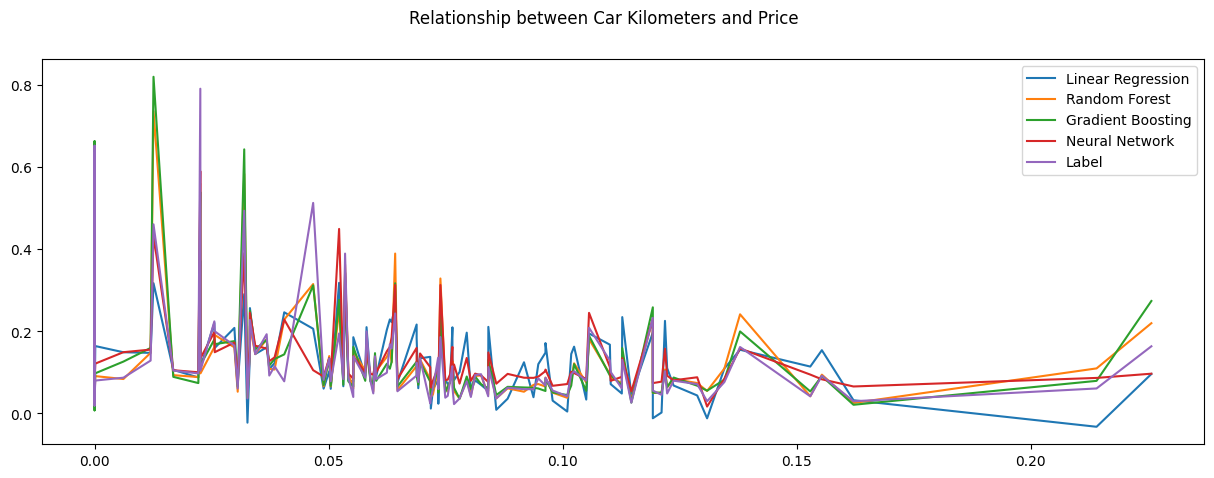

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

fig.suptitle('Relationship between Car Kilometers and Price')

ax.plot(X_test['car_km'], X_test['lin_reg_pred'], label='Linear Regression')
ax.plot(X_test['car_km'], X_test['rf_reg_pred'], label='Random Forest')
ax.plot(X_test['car_km'], X_test['gb_reg_pred'], label='Gradient Boosting')
ax.plot(X_test['car_km'], X_test['nn_reg_pred'], label='Neural Network')
ax.plot(X_test['car_km'], X_test['car_price'], label='Label')

plt.legend()
plt.show()

---

## Referêncais

Data Treatment
- https://pypi.org/project/fancyimpute/#description

Regression Models
- [Linear Regression] https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- [Random Forest Regressor] https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
- [Gradient Boosting Regressor] https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor
- [Neural Network Rsgressor] https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

Further Reading
- https://keras.io/examples/keras_recipes/reproducibility_recipes/

Automated Optimization
- [Optuna - A hyperparameter optimization framework] https://optuna.org/
- https://automl.github.io/auto-sklearn/master/index.html

Didactic Material
- https://towardsdatascience.com/7-of-the-most-commonly-used-regression-algorithms-and-how-to-choose-the-right-one-fc3c8890f9e3